In [1]:
using PyCall

PS4C_dir = "/home/zequnl/Projects/PS4C/model/lagache/"

"/home/zequnl/Projects/PS4C/model/lagache/"

In [2]:
fgspectra = pyimport("fgspectra")
fgc = pyimport("fgspectra.cross")
fgp = pyimport("fgspectra.power")
fgf = pyimport("fgspectra.frequency")

np = pyimport("numpy")

PyObject <module 'numpy' from '/tigress/zequnl/conda_envs/ps/lib/python3.8/site-packages/numpy/__init__.py'>

In [4]:
freq1 = 100.0
int_freq1 = Int(freq1)

freq2 = 143.0
int_freq2 = Int(freq2)

143

In [5]:
# PS4C_freqs = ["100"]
# lagache_counts = [
#     np.genfromtxt(PS4C_dir * "ns$(freq)_radio.dat", 
#                   names=("S", "dNdS"))  
#     for freq in PS4C_freqs];

In [6]:
using HDF5

flux_143 = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(143.0).h5", "flux");

flux1 = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq1).h5", "flux")
θ1 = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq1).h5", "theta")
ϕ1 = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq1).h5", "phi");

flux2 = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq2).h5", "flux")
θ2 = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq2).h5", "theta")
ϕ2 = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq2).h5", "phi");

In [ ]:
using XGPaint
using Healpix
hp = pyimport("healpy")

using PyPlot
using Unitful, UnitfulAstro
import PhysicalConstants.CODATA2018: BoltzmannConstant, PlanckConstant, SpeedOfLightInVacuum

# CHANGE FOR DIFFERENT FREQUENCY ==========================
# print(KCMB_to_Jy_factor(freq * 1u"GHz"))

const TCMB = 2.725u"K"
xf(ν) = float(PlanckConstant) * ν / float(BoltzmannConstant) / TCMB
MJy_mul(ν) = 1.05e3 * expm1(xf(ν))^2 * exp(-xf(ν)) * (ν/100u"GHz")^(-4)
tSZ_mul(ν) = 1e6u"1/K" * TCMB * (xf(ν) * (exp(xf(ν))+1) / expm1(xf(ν)) - 4)

In [ ]:
MJy_mul(freq1 * 1u"GHz"), tSZ_mul(freq1 * 1u"GHz")

# Generate Radio Map

In [ ]:
nside = 4096
m_radio1 = Map{Float64,RingOrder}(nside)
m_radio2 = Map{Float64,RingOrder}(nside)

flux_cut = 7e-3
cut_array = flux_143 .< flux_cut  # in Jy
XGPaint.catalog2map!(m_radio1, flux1[cut_array], θ1[cut_array], ϕ1[cut_array])
XGPaint.catalog2map!(m_radio2, flux2[cut_array], θ2[cut_array], ϕ2[cut_array])

# XGPaint.catalog2map!(m_radio, flux, θ, ϕ)

MJy_factor1 = MJy_mul(freq1 * 1u"GHz")
m_radio1 .*= MJy_factor1 / 1e6;  # CONVERT TO muK, note that our maps are in Jy/sr
MJy_factor2 = MJy_mul(freq2 * 1u"GHz")
m_radio2 .*= MJy_factor2 / 1e6;  # CONVERT TO muK, note that our maps are in Jy/sr

In [ ]:

# XGPaint.catalog2map!(m_radio, flux[cut_array], θ[cut_array], ϕ[cut_array])

In [ ]:
using AngularPowerSpectra

# compute binning matrix
P = binning_matrix(0:50:2nside, 50:50:2nside+50, ℓ -> ℓ^2, lmax=3nside);
lb = P * collect(0:3nside-1)
pixwin = hp.pixwin(nside);

In [ ]:
using FITSIO

m_cib1 = readMapFromFITS("/tigress/zequnl/websky/cib_nu0$(int_freq1).fits", 1, Float64);
m_cib1.pixels .*= MJy_factor1

tSZ_factor1 = tSZ_mul(freq1 * 1u"GHz")
m_tsz1 = readMapFromFITS("/tigress/zequnl/websky/tsz.fits", 1, Float64);
m_tsz1 .*= tSZ_factor1;

In [ ]:
alm_radio1 = map2alm(m_radio1)
alm_radio2 = map2alm(m_radio2);

In [ ]:
alm_cib1 = map2alm(m_cib1)
alm_tsz1 = map2alm(m_tsz1);

In [ ]:
run(`ls /tigress/zequnl/sehgal/`)

In [ ]:
m_radio_sehgal1 = readMapFromFITS("/tigress/zequnl/sehgal/$(int_freq1)_rad_pts_healpix_nopell_Nside4096_DeltaT_uK_fluxcut148_7mJy_lininterp.fits", 1, Float64);
alm_radio_sehgal1 = map2alm(m_radio_sehgal1);

In [ ]:
# m_tsz_sehgal_100 = readMapFromFITS("/tigress/zequnl/sehgal/090_tsz_healpix.fits", 1, Float64);
# print( sum(m_tsz_sehgal_100) / 4π / Jy_mul_factor )
# m_tsz_sehgal_100.pixels ./= Jy_mul_factor
# alm_tsz_sehgal = map2alm(m_tsz_sehgal_100);

# ALL IS microK

In [ ]:
cl_radio_radio = alm2cl(alm_radio)
cl_cib_cib = alm2cl(alm_cib)
cl_tsz_tsz = alm2cl(alm_tsz)

cl_radio_cib = alm2cl(alm_radio, alm_cib)
cl_cib_tsz = alm2cl(alm_cib, alm_tsz)
cl_radio_tsz = alm2cl(alm_radio, alm_tsz);

In [ ]:
plt.plot(alm2cl(alm_radio_sehgal) ./ pixwin.^2, "-", label="Sehgal/Colin reprocessed")
plt.plot(cl_radio_radio  ./ pixwin.^2, "--", label="WEBSKY $(freq) GHz")

yscale("log")
# xlim(0,2nside)
ylim(1e-12,1e-3)
# ylabel(raw"$C_{\ell}$ [$\mu$K$^2$]")
legend()

In [ ]:
# m_cib_sehgal = readMapFromFITS(
#     "/tigress/zequnl/sehgal/100_ir_pts_healpix_nopell_Nside4096_DeltaT_uK_lininterp_CIBrescale0p75.fits", 1, Float64);
# alm_cib_sehgal = map2alm(m_cib_sehgal);

In [ ]:
# cl_cib_cib_sehgal = alm2cl(alm_cib_sehgal);

In [ ]:
sum(m_radio.pixels) / nside2npix(nside)

In [ ]:
sum(m_cib.pixels) / nside2npix(nside)

In [ ]:
sum(m_tsz.pixels) / nside2npix(nside)

In [ ]:
# plt.plot(radio_model ./ ells.^2 / 2π, "-", lw=2)

title("$(freq) GHz")

plt.plot(lb, P * (cl_radio_radio ./ pixwin.^2) .* lb.^2, "-", label="websky radio")
# plt.plot(cibc_model ./ ells.^2 / 2π, lw=3, label="CIB clustered model from Dunkley+13")
# plt.plot(cibp_model .* 1e2, "-", lw=3, label="CIB poisson model from Dunkley+13")

plt.plot(lb, P * (cl_tsz_tsz ./ pixwin.^2) .* lb.^2  , "-", label="websky tSZ")
plt.plot(lb, P * (cl_cib_cib ./ pixwin.^2) .* lb.^2 , "--", label="websky CIB")
# plt.plot(lb, P * (cl_cib_cib_sehgal ./ pixwin.^2).* lb.^2, "-", label="sehgal CIB")

ylabel(raw"$\ell^2 C_{\ell}$ [$\mu$K$^2$]")


# plt.plot(lb, P * (cl_tsz_tsz .* 2e12), "-")
legend()
yscale("log")
xscale("log")
ylim(1e-2, 1e3)
savefig("spectra$(freq).pdf")
# ylim(0,1e-4)

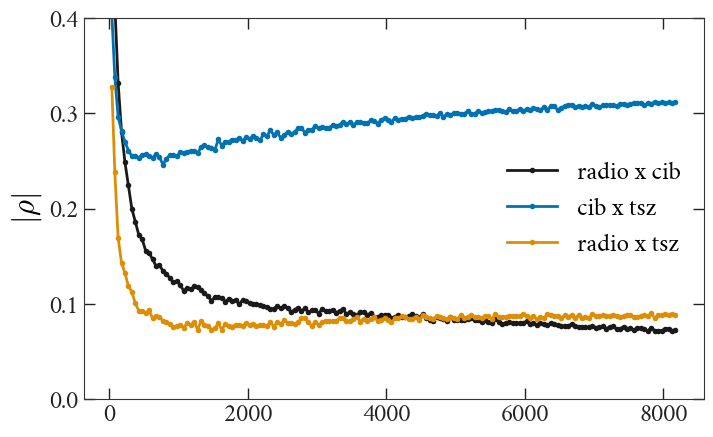

'Cochineal-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [48]:
using AngularPowerSpectra

# plot(lb, P * (cl_radio_radio ./ pixwin))
# plot(lb, P * (cl_cib_cib ./ pixwin))

plot(lb, P * (cl_radio_cib ./ sqrt.(cl_radio_radio .* cl_cib_cib) ), label="radio x cib")
plot(lb, P * abs.(cl_cib_tsz ./ sqrt.(cl_tsz_tsz .* cl_cib_cib) ), label="cib x tsz")
plot(lb, P * abs.(cl_radio_tsz ./ sqrt.(cl_radio_radio .* cl_tsz_tsz) ), label="radio x tsz")

legend()

ylabel(raw"$|\rho|$")
# ylim(0,2e3)
ylim(0.0, 0.4)
# xlim(0,2nside)
# yscale("log")

savefig("correlations_143.pdf")

In [26]:
ells = collect(0:3nside-1)
fwhm_100 = 2.2 * π/(60 * 180)
bl = hp.gauss_beam(fwhm_100, lmax=3nside);

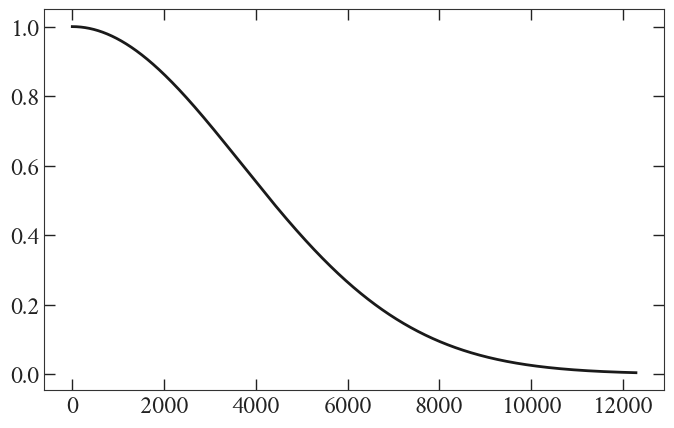

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x2ae720c8c8b0>

In [27]:
plot(bl, "-")

In [28]:
ENV["SCRATCH"] = "/tigress/zequnl/xgpaint/"
@time halo_pos, halo_mass = read_halo_catalog_hdf5(
    joinpath(ENV["SCRATCH"],"websky_halos-light.hdf5"));

 32.671598 seconds (283.25 k allocations: 25.731 GiB, 0.08% gc time)


In [29]:
beamed_radio = hp.sphtfunc.smoothing(m_radio.pixels, fwhm=fwhm_100);
beamed_cib = hp.sphtfunc.smoothing(m_cib.pixels, fwhm=fwhm_100);
beamed_tsz = hp.sphtfunc.smoothing(m_tsz.pixels, fwhm=fwhm_100);

In [30]:
mass_cut_array = halo_mass .> 10^14.5
positions = halo_pos[:, mass_cut_array];

In [31]:
norm(x) = sqrt(x[1]^2 + x[2]^2 + x[3]^2)
unitize(x) = x ./ norm(x)

unitize (generic function with 1 method)

In [32]:
max_disc_in_arcmin = 6
max_disc = deg2rad(max_disc_in_arcmin / 60)

0.0017453292519943296

In [33]:
using ProgressMeter

function get_discs(beamed_map::Array{T}, res, pos) where T
#     res = beamed_map.resolution
    radii = T[]
    disc_fluxes = T[]
    
    num_halos = size(pos, 2)
    @showprogress for i in 1:num_halos
        pixel_inds = hp.query_disc(nside, unitize(positions[:,i]), max_disc) .+ 1
        append!(disc_fluxes, beamed_map[pixel_inds])
        vec1 = unitize(positions[:,i]) #pix2vecRing(res, vec2pixRing(res, positions[:,i]...))
        vec2 = hp.pixelfunc.pix2vec(res.nside, pixel_inds .- 1) #[pix2angRing(res, pixind) for pixind in pixel_inds]
#         angdists = [hp.rotator.angdist(vec1, [vec2[1][i_discpix], vec2[2][i_discpix]])[1] for i_discpix in 1:length(pixel_inds) ]
        angdists = hp.rotator.angdist(vec1, vec2)
        append!(radii, angdists)
    end
    
    return radii, disc_fluxes
end

get_discs (generic function with 1 method)

In [34]:
using Interpolations
spline(x, y) = scale(interpolate(y, BSpline(Cubic(Line(OnGrid())))), x)
spline_∂ₓ(f, x_grid) = spline(x_grid, [Interpolations.gradient(f, x)[1] for x in x_grid])


spline_∂ₓ (generic function with 1 method)

In [72]:
# function get_profile(m, res)
#     r, f = get_discs(m, res, positions)
#     Δr = max_disc/30
#     radial_coord = Δr/100:Δr:max_disc
#     cumulative_fluxes = [sum(f[r .< r₀]) for r₀ in radial_coord];
#     profile = spline_∂ₓ(spline(radial_coord, cumulative_fluxes), radial_coord)
#     return profile
# end

In [95]:
function get_profile(m, res)
    r, f = get_discs(m, res, positions)
    Δr = max_disc/30
    radial_coord = 0.0:Δr:max_disc
    cumulative_fluxes = [
        sum( f[((r₀-Δr) .< r) .& (r .< (r₀+Δr))] ) / (π * ((r₀+Δr)^2 - max(0.0, r₀-Δr)^2))
        for r₀ in radial_coord];
    cumulative_fluxes[1] = sum( f[r .< Δr] ) / (π * Δr^2) 
    
    profile = spline(radial_coord, cumulative_fluxes) #spline_∂ₓ(
        
#         , radial_coord)
    return profile
end

get_profile (generic function with 1 method)

In [121]:
# profile_radio = get_profile(beamed_radio, m_radio.resolution)
# profile_tsz = get_profile(beamed_tsz, m_radio.resolution)
# profile_cib = get_profile(beamed_cib, m_radio.resolution);

profile_radio = get_profile(m_radio.pixels, m_radio.resolution)
profile_tsz = get_profile(m_tsz.pixels, m_radio.resolution)
profile_cib = get_profile(m_cib.pixels, m_radio.resolution);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


In [107]:
# r, fr = get_discs(m_radio.pixels, m_radio.resolution, positions)
# r, fsz = get_discs(beamed_tsz, m_radio.resolution, positions)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


([0.0017221862741023776, 0.0017202446058567327, 0.0017421975862253762, 0.0016117514762667867, 0.0015322614044748916, 0.0015117867344921446, 0.0015526639077682181, 0.0016503403243592661, 0.0016211677798015159, 0.0014610889200242488  …  0.0015576548972699158, 0.0014258857072322788, 0.0013834551983640325, 0.0014382918645276408, 0.0015803023930831017, 0.0016402458893535984, 0.0015602001844434543, 0.0015658838228943862, 0.0016564145529296768, 0.0017206450788672723], [0.0, 0.0, 0.0, 0.0, 0.4933860543637618, 0.0, 0.15444135093503503, 0.036198739809608506, 0.0, 0.7255338542560896  …  0.0, 0.0, 0.0, 1.3695093342106148, 0.0, 0.3597315761367854, 0.0, 1.6960738679739944, 0.0, 0.2316849690730539])

In [103]:
# sum(fr) / sum(fsz)

In [122]:
Δr = max_disc/30
plotting_r = Δr/10:max_disc/1000:(max_disc-Δr)

5.817764173314432e-6:1.7453292519943296e-6:0.001686569833843854

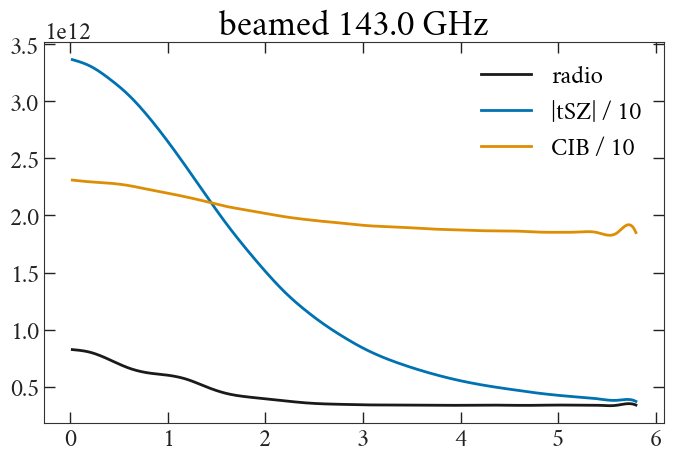

PyObject Text(0.5, 1.0, 'beamed 143.0 GHz')

In [123]:

r_arcmin = rad2deg.(plotting_r) .* 60

plot(r_arcmin, profile_radio.(plotting_r), "-", label="radio")
plot(r_arcmin, abs.(profile_tsz.(plotting_r)) ./ 10  , "-", label="|tSZ| / 10")
plot(r_arcmin, profile_cib.(plotting_r) ./ 10, "-", label="CIB / 10")
# plot(radial_coord, predict(approx, radial_coord), "-")
legend()
# yscale("log")
title("beamed $(freq) GHz")
# ylim(0.0, 1e19)


In [92]:
# r_arcmin = rad2deg.(plotting_r) .* 60
# plot(r_arcmin, profile_radio.(plotting_r) ./ ( π .* ((plotting_r .+ Δr/50).^2 - (plotting_r .- Δr/50).^2)), "-", label="radio")
# plot(r_arcmin, abs.(profile_tsz.(plotting_r)) ./ ( π .* ((plotting_r .+ Δr/50).^2 - (plotting_r .- Δr/50).^2)), "-", label="|tSZ|")
# plot(r_arcmin, profile_cib.(plotting_r) ./ ( π .* ((plotting_r .+ Δr/50).^2 - (plotting_r .- Δr/50).^2)), "-", label="CIB")
# # plot(radial_coord, predict(approx, radial_coord), "-")
# legend()
# yscale("log")
# title(freq)
# # ylim(0.0, 0.5e20)

In [93]:
rad2deg(sqrt(nside2pixarea(nside))) * 60

0.8588716029543515

In [94]:
360 * 60 / 3nside

1.7578125